In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
class Lang:
    EoS_token = 0

    def __init__(self, name) -> None:
        self.name = name

        self.word2index = {}
        self.index2word = {0: '<EoS>'}
        self.word2count = {}
        self.n_words = 1

    def addWord(self, word):
        if word in self.word2index:
            self.word2count[word] += 1
        else:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def encode(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')] + [Lang.EoS_token]
    
    def decode(self, idx):
        return ' '.join([self.index2word[i] for i in idx])

In [13]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [14]:
import pathlib
data_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/nlp_data"


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = '%s-%s.txt' % (lang1, lang2)
    lines = open(f"{data_root}/{file_name}" , encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [16]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4600
eng 2990
['je suis heureux que tom fut a mes cotes', 'i m glad tom was there with me']


In [17]:
input_lang.decode(input_lang.encode(pairs[0][0]))

'je vais bien <EoS>'

In [18]:
def get_dataloader(input_lang, output_lang, pairs, batch_size):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = input_lang.encode(inp)
        tgt_ids = output_lang.encode(tgt)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [19]:
batch_size = 32
input_lang, output_lang, train_dataloader = get_dataloader(input_lang, output_lang, pairs, batch_size)

In [20]:
inputs, outputs = next(iter(train_dataloader))
print(inputs.shape, outputs.shape)

torch.Size([32, 10]) torch.Size([32, 10])


In [21]:
print(inputs)

tensor([[ 204, 2046,  900,  142, 2513,   63,   59,  652,    0,    0],
        [ 142,   20, 1148,  115,  900,    1,    6, 1092,    0,    0],
        [ 120,  123,  112,  617,  231, 1613,    0,    0,    0,    0],
        [ 115, 1062,  161, 1418,    0,    0,    0,    0,    0,    0],
        [ 204,   20, 2182,  353,    0,    0,    0,    0,    0,    0],
        [   1, 1125,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   22, 1655,   98,  923, 3018,    0,    0,    0,    0],
        [   1, 4510,  526, 2108, 1071,  424,  712, 1196,    0,    0],
        [ 208,  209, 1342,    0,    0,    0,    0,    0,    0,    0],
        [  19,   20,  931, 2311,  200, 1850,    0,    0,    0,    0],
        [ 120,  123, 1265,    0,    0,    0,    0,    0,    0,    0],
        [ 208,  209,  238,   98,  967,    0,    0,    0,    0,    0],
        [ 116,   20, 3390,   98,  705,  775,    0,    0,    0,    0],
        [  86,   19, 1593,  200, 1106,    0,    0,    0,    0,    0],
        [ 116,   45,

# Seq2Seq

## Encoder

![Encoder](images/seq2seq-rnn-encoder.png)

## Decoder

![Rnn Decoder](images/seq2seq-rnn-decoder.png)


In [22]:
class EncoderGru(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_p = 0.1) -> None:
        super().__init__()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.droupout = nn.Dropout(dropout_p)

    def forward(self, idx):
        # (B, T)
        embedded = self.embedding(idx)
        embedded = self.droupout(embedded)
        output, hidden = self.gru(embedded)
        return output, hidden

In [24]:
hidden_size = 128
encoder = EncoderGru(input_lang.n_words, hidden_size)

outputs, hidden = encoder(inputs)

print(outputs.shape, hidden.shape)

torch.Size([32, 10, 128]) torch.Size([1, 32, 128])


In [108]:
class DecoderGru(nn.Module):

    def __init__(self, hidden_size, output_size) -> None:
        super().__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward_step(self, idx, hidden):
        # idx: (B, 1)
        # print(idx.shape, hidden.shape)
        embedded = self.embedding(idx)
        embedded = F.relu(embedded)
        output, hidden = self.gru(embedded, hidden)
        output = self.fc(output)
        # print('output', output.shape) (B, 1, output_dim)
        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden, target=None):
        # (B, T, emb)
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.int32, device=device).fill_(Lang.EoS_token)
        decoder_hidden = encoder_hidden
        outputs = []
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            outputs.append(decoder_output)

            if target is not None:
                decoder_output = target[:, i].unsqueeze(dim=1)
            else:
                _, topi = decoder_output.topk(1, dim=-1) # (B, output_size)
                decoder_input = topi.squeeze(dim=1).detach()

        outputs = torch.cat(outputs, dim=1)
        outputs = F.log_softmax(outputs, dim=-1)
        return outputs, decoder_hidden, None # attention_weights

In [53]:
torch.cat((torch.randn((batch_size, 1, output_lang.n_words)),torch.randn((batch_size, 1, output_lang.n_words))), dim=1).shape

torch.Size([32, 2, 2990])

In [54]:
decoder = DecoderGru(hidden_size, output_lang.n_words)

decoder(outputs, hidden)

torch.Size([32, 1, 1]) tensor([[[1525]],

        [[1470]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[ 527]],

        [[1289]],

        [[1289]],

        [[1841]],

        [[ 155]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1289]],

        [[1470]],

        [[1289]],

        [[1289]],

        [[2576]],

        [[ 499]],

        [[ 527]],

        [[1289]],

        [[1142]],

        [[1289]],

        [[ 499]],

        [[1470]]])
torch.Size([32, 1, 1]) tensor([[[1142]],

        [[1470]],

        [[ 259]],

        [[ 259]],

        [[ 259]],

        [[ 259]],

        [[2499]],

        [[2834]],

        [[ 259]],

        [[2836]],

        [[2836]],

        [[ 259]],

        [[ 259]],

        [[ 259]],

        [[ 259]],

        [[ 259]],

        [[2101]],

        [[ 259]],

    

(tensor([[[-8.0104, -8.1406, -8.0431,  ..., -8.1016, -8.1207, -7.8055],
          [-8.2168, -8.2713, -7.9808,  ..., -7.9755, -7.9415, -7.6907],
          [-8.1723, -8.2766, -7.9032,  ..., -7.9231, -7.8878, -7.7506],
          ...,
          [-8.1705, -8.2095, -8.0156,  ..., -8.1655, -7.8051, -8.0428],
          [-8.2091, -8.2926, -8.0276,  ..., -8.0681, -7.7815, -8.0388],
          [-8.2005, -8.1610, -7.8697,  ..., -8.0076, -7.6875, -7.9919]],
 
         [[-7.9906, -8.0401, -8.0555,  ..., -8.0877, -8.1062, -7.7076],
          [-8.1597, -8.2225, -7.8708,  ..., -8.2038, -7.9797, -7.6363],
          [-8.2745, -8.2939, -7.7963,  ..., -8.2672, -7.9442, -7.5899],
          ...,
          [-8.3979, -8.3487, -7.7150,  ..., -8.3078, -7.9372, -7.5178],
          [-8.3996, -8.3490, -7.7124,  ..., -8.3089, -7.9387, -7.5134],
          [-8.4003, -8.3491, -7.7108,  ..., -8.3097, -7.9396, -7.5105]],
 
         [[-7.9719, -8.0082, -8.0135,  ..., -8.0849, -8.1609, -7.7103],
          [-8.0564, -8.1422,

In [56]:
hidden_size = 128

learning_rate = 0.001

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [57]:
def train_epoch(dataloader, encoder, decoder, encoder_optim, decoder_optim, criterion):
    total_loss = 0.0

    for inputs, targets in dataloader:

        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        encoder_outputs, encoder_hidden = encoder(inputs)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, targets)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            targets.view(-1)
        )
        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [58]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [59]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [60]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [61]:
encoder = EncoderGru(input_lang.n_words, hidden_size).to(device)
decoder = DecoderGru(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

0m 35s (- 8m 55s) (5 6%) 1.9900
1m 10s (- 8m 12s) (10 12%) 1.3068
1m 43s (- 7m 29s) (15 18%) 0.9616
2m 16s (- 6m 48s) (20 25%) 0.7330
2m 53s (- 6m 21s) (25 31%) 0.5770
3m 28s (- 5m 47s) (30 37%) 0.4677
4m 3s (- 5m 13s) (35 43%) 0.3881
4m 36s (- 4m 36s) (40 50%) 0.3285
5m 8s (- 4m 0s) (45 56%) 0.2822
5m 40s (- 3m 24s) (50 62%) 0.2441
6m 11s (- 2m 49s) (55 68%) 0.2135
6m 48s (- 2m 16s) (60 75%) 0.1886
7m 19s (- 1m 41s) (65 81%) 0.1682
7m 56s (- 1m 8s) (70 87%) 0.1519
8m 29s (- 0m 33s) (75 93%) 0.1368
9m 1s (- 0m 0s) (80 100%) 0.1264


<Figure size 640x480 with 0 Axes>

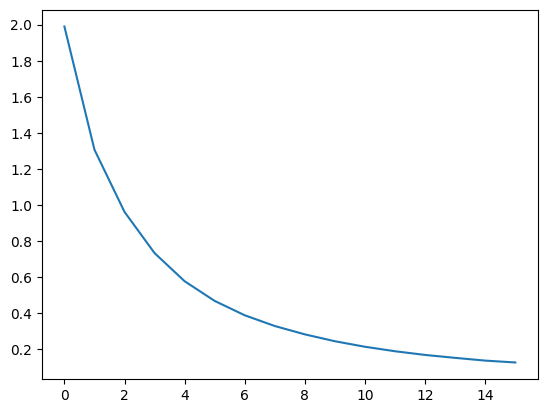

In [62]:
%matplotlib inline

plt.show()

In [111]:
def encode(lang, sentence):
    tensor = torch.zeros(MAX_LENGTH, dtype=torch.int32)
    ids = lang.encode(sentence)
    for i, idx in enumerate(ids):
        tensor[i] = idx
    return tensor.unsqueeze(0)

In [112]:
def translate(encoder, decoder, input_sentence, input_lang, output_lang):
    with torch.no_grad():
        ids = encode(input_lang, input_sentence)
        ids.to(device)
        encoder_outputs, encoder_hidden = encoder(ids)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)
        _, topi = decoder_outputs.topk(1, dim=-1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == Lang.EoS_token:
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, None

In [113]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs, n=10):
    encoder.eval()
    decoder.eval()
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = translate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [114]:

evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs)

> ils viennent nous chercher
= they re coming for us
torch.Size([1, 1, 1]) tensor([[[219]]])
torch.Size([1, 1, 1]) tensor([[[76]]])
torch.Size([1, 1, 1]) tensor([[[140]]])
torch.Size([1, 1, 1]) tensor([[[737]]])
torch.Size([1, 1, 1]) tensor([[[742]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
< they re coming for us

> tu es assez vieux pour savoir mieux
= you re old enough to know better
torch.Size([1, 1, 1]) tensor([[[127]]])
torch.Size([1, 1, 1]) tensor([[[76]]])
torch.Size([1, 1, 1]) tensor([[[39]]])
torch.Size([1, 1, 1]) tensor([[[513]]])
torch.Size([1, 1, 1]) tensor([[[530]]])
torch.Size([1, 1, 1]) tensor([[[1824]]])
torch.Size([1, 1, 1]) tensor([[[87]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
torch.Size([1, 1, 1]) tensor([[[0]]])
< you re old enough to know better

> c est un scientifique qui est 

# Attention

![Attention](images/seq2seq-rnn-attention.png)

In [122]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        # query: (B, H) or (B, 1, H)
        # keys: (B, T, H)
        # -> ((B, H) + (B, T, H)) -> (B, T, H) -> (B, T, 1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1) # (B, 1, T)

        weights = F.softmax(scores, dim=-1) # (B, 1, T)
        context = torch.bmm(weights, keys) # (B, 1, T) @ (B, T, H) -> (B, 1, H)

        return context, weights

In [121]:
keys = torch.tensor([[
    [1, 1, 1],
    [2, 2, 2]
]]).float()

scores = ((torch.tensor([
    [1, 1, 1]
]).float() + keys) @ torch.ones((3, 1)).float()).squeeze(2).unsqueeze(1)

weights = F.softmax(scores, dim=-1)
context = torch.bmm(weights, keys)

print(weights)
print(context)

tensor([[[0.0474, 0.9526]]])
tensor([[[1.9526, 1.9526, 1.9526]]])


In [123]:
hidden.shape

torch.Size([1, 32, 128])

In [132]:
class AttentionDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p = 0.1) -> None:
        super().__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward_step(self, idx, hidden, encoder_outputs):
        # hidden = (1, B, H)
        embedded = self.embedding(idx) # (B, H)
        embedded = self.dropout(embedded)
        query = hidden.permute(1, 0, 2) # (B, 1, H)
        # encoder_outputs: (B, T, H)
        attn_context, attn_weights = self.attention(query, encoder_outputs)
        # embedded: (B, H) or (B, 1, H), context: (B, 1, H)
        combined = torch.cat((embedded, attn_context), dim=2) # -> (B, 1, 2 * H)
        output, hidden = self.gru(combined, hidden) # -> (B, 1, H)
        output = self.fc(output) # -> (B, 1, output_size)
        return output, hidden, attn_weights
    
    def forward(self, encoder_outputs, encoder_hidden, targets=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.int32, device=device).fill_(Lang.EoS_token)
        decoder_hidden = encoder_hidden
        outputs = []
        attentions = []
        
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            outputs.append(decoder_output)
            attentions.append(attn_weights)

            if targets is None:
                _, topi = decoder_output.topk(1, dim=-1)
                decoder_input = topi.squeeze(dim=-1).detach()
            else:
                decoder_input = targets[:, i].unsqueeze(1)
        
        decoder_outputs = torch.cat(outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions
        


0m 53s (- 13m 18s) (5 6%) 1.5566
1m 46s (- 12m 28s) (10 12%) 0.7020
2m 47s (- 12m 4s) (15 18%) 0.3699
3m 48s (- 11m 24s) (20 25%) 0.2079
4m 42s (- 10m 21s) (25 31%) 0.1285
5m 36s (- 9m 20s) (30 37%) 0.0886
6m 36s (- 8m 30s) (35 43%) 0.0672
7m 34s (- 7m 34s) (40 50%) 0.0546
8m 23s (- 6m 31s) (45 56%) 0.0470
9m 14s (- 5m 32s) (50 62%) 0.0413
10m 7s (- 4m 36s) (55 68%) 0.0378
10m 56s (- 3m 38s) (60 75%) 0.0353
11m 50s (- 2m 43s) (65 81%) 0.0339
12m 40s (- 1m 48s) (70 87%) 0.0313
13m 29s (- 0m 53s) (75 93%) 0.0308
14m 19s (- 0m 0s) (80 100%) 0.0295


<Figure size 640x480 with 0 Axes>

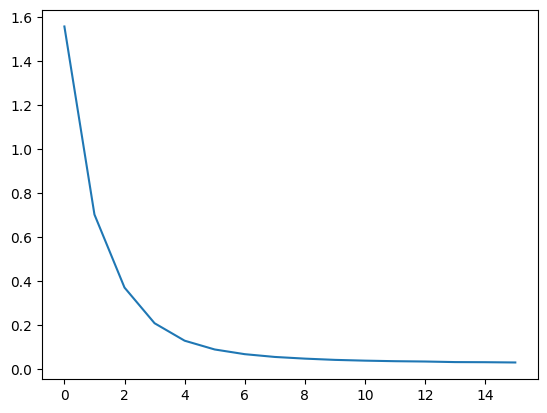

In [133]:
encoder = EncoderGru(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoder(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [137]:
evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs)

> je suis tout a toi
= i m all yours
< i m all yours

> tu n es d aucune aide
= you re no help
< you re no help

> il enseigne depuis ans
= he s been teaching for years
< he s been teaching for years

> nous sommes trop occupes
= we re too busy
< we re too busy

> je ne suis vraiment pas occupee
= i m really not busy
< i m really not busy

> je suis en train de regarder la television
= i m just watching tv
< i m watching tv

> j en ai assez d attendre
= i m tired of waiting
< i m tired of waiting

> nous sortons ensemble
= we re dating
< we re dating

> elles sont jalouses de nous
= they are jealous of us
< they are jealous of us

> il est plutot difficile a contenter
= he is rather hard to please
< he is rather hard to please



In [159]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [160]:
def translateAttn(encoder, decoder, input_sentence, input_lang, output_lang):
    with torch.no_grad():
        ids = encode(input_lang, input_sentence)
        ids.to(device)
        encoder_outputs, encoder_hidden = encoder(ids)
        decoder_outputs, _, attentions = decoder(encoder_outputs, encoder_hidden)
        _, topi = decoder_outputs.topk(1, dim=-1)
        decoded_ids = topi.squeeze()
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == Lang.EoS_token:
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, attentions

> il n est pas aussi grand que son pere
= he is not as tall as his father
torch.Size([1, 10, 10])


/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


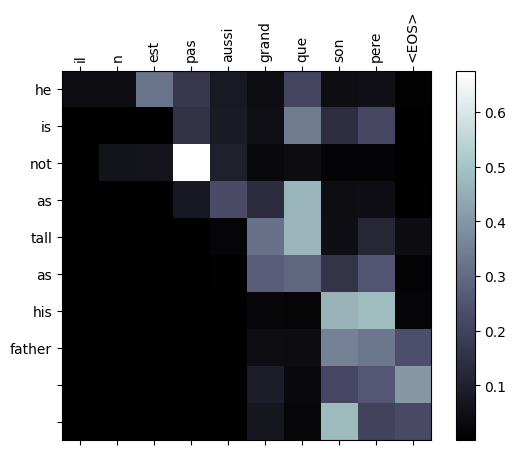

In [161]:
def evaluateAndShowAttentions(encoder, decoder, input_lang, output_lang, input_sentence):
    encoder.eval()
    decoder.eval()
    decoded_words, attentions = translateAttn(encoder, decoder, input_sentence, input_lang, output_lang)
    print('>', input_sentence)
    print('=', ' '.join(decoded_words))
    print(attentions.shape)
    showAttention(input_sentence, decoded_words, attentions.squeeze(0))

evaluateAndShowAttentions(encoder, decoder, input_lang, output_lang, 'il n est pas aussi grand que son pere')

> je suis trop fatigue pour conduire
= i m too tired to drive
torch.Size([1, 10, 10])


/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


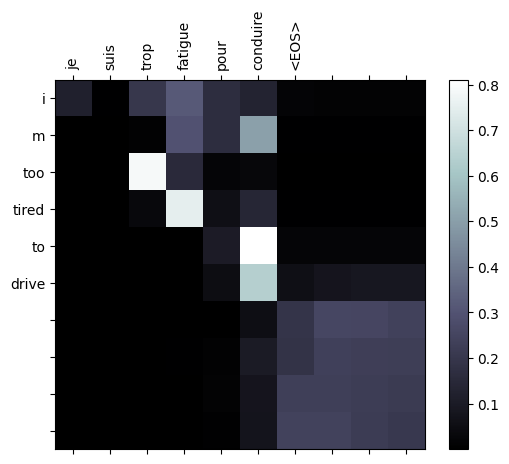

In [147]:
evaluateAndShowAttentions(encoder, decoder, input_lang, output_lang, 'je suis trop fatigue pour conduire')

> je suis desole si c est une question idiote
= i m sorry if this is a stupid question
torch.Size([1, 10, 10])


/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


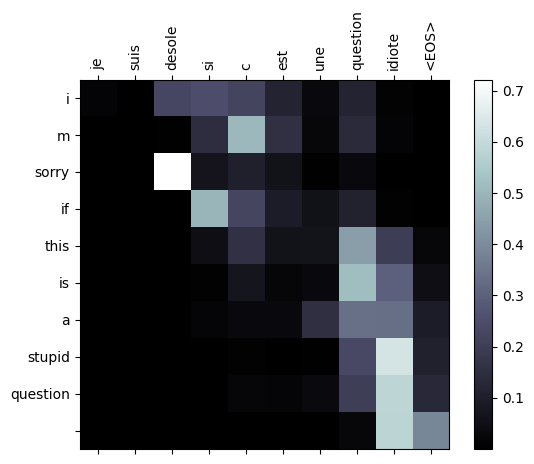

In [148]:
evaluateAndShowAttentions(encoder, decoder, input_lang, output_lang, 'je suis desole si c est une question idiote')

> je suis reellement fiere de vous
= i m really proud of you
torch.Size([1, 10, 10])


/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6h/15ndlbdd5jl8rr8hqbhn5zz40000gn/T/ipykernel_6192/3679898558.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


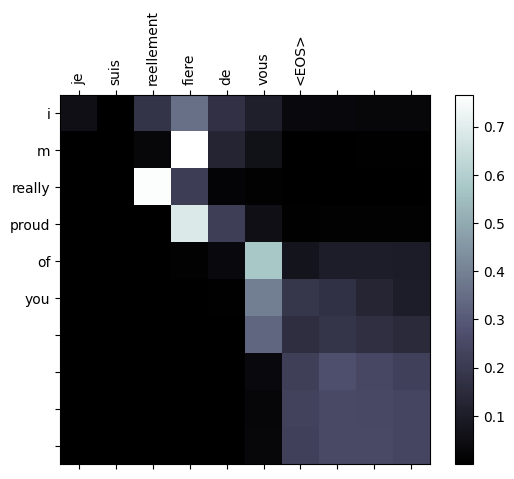

In [162]:
evaluateAndShowAttentions(encoder, decoder, input_lang, output_lang, 'je suis reellement fiere de vous')